# Exploring the role of ESRP1 expression in prostate cancer

In this notebook, we will explore the role of ESRP1 expression in prostate cancer, where it is commonly amplified and correlated with worsened prognosis. We will obtain splicing quantification across the TCGA-PRAD cohort using data from [TCGASpliceSeq](https://bioinformatics.mdanderson.org/TCGASpliceSeq/), and project PTMs onto the splice events that were identified by SpliceSeq. We will then explore the various ways ESRP1 expression may drive changes through changes to PTM inclusion and flanking sequences. The analysis here is similar to Figures 4 and 5 of our [manuscript](https://www.biorxiv.org/content/10.1101/2024.01.10.575062v2)

This notebook is divided into the following sections:
1. Load ESRP1 expression data from [CBioPortal](https://www.cbioportal.org/)
2. Project PTMs onto splice events and identify events that are correlated with ESRP1 expression
3. Explore the functional consequence of ESRP1-correlated PTMs

## Project PTMs onto splice events and identify events that are correlated with ESRP1 expression

First, we want to identify PTMs associated with the SpliceSeq splicegraph. Luckily for us, there is a built in function within PTM-POSE that allows us to easily project PTMs onto the splice events from TCGASpliceSeq. Once the event data is downloaded, we can run the following code to process the data. This assumes that spliceseq is running in hg19 coordinates (TCGASpliceSeq data is).

In [ ]:
from ptm_pose import project
import pandas as pd

#load data from TCGASpliceSeq
psi_data = pd.read_csv('./TCGA_data/PSI_download_PRAD.txt', sep = '\t')
psi_data.index = psi_data['GeneSymbol']
splicegraph = pd.read_csv('./TCGA_data/TCGASpliceData.txt', sep = '\t')

#identifying TCGA columns containing patient PSI data
patient_columns = [col for col in psi_data.columns if 'TCGA' in col]

psi_data, spliced_ptms = project.project_ptms_onto_SpliceSeq(psi_data, splicegraph = splicegraph, extra_cols = patient_columns)

Removing ME events from analysis
Projecting PTMs onto SpliceSeq data


Projecting PTMs onto splice events using hg19 coordinates.: 100%|██████████| 62861/62861 [34:18<00:00, 30.54it/s]


PTMs projection successful (76363 identified).



In [ ]:
psi_data.to_csv('./TCGA_data/annotated_PSI_data.csv', index = False)
spliced_ptms.to_csv('./TCGA_data/TCGA_spliced_PTMs.csv', index = False)

## Identify ESRP1-related splice events

In order to understand PTMs that are related to ESRP1 expression, we first need to identify which splice events impact PTMs are related to ESRP1 expression. This is not directly a part of PTM-POSE, but provides a nice example of how you can pair analysis of the original splicing data to those of PTM-POSE. Note, we are focusing on ESRP1 expression here, but we could easily do this for any other protein of interest.

### Load ESRP1 expression data from CBioPortal

While this is not a part of PTM-POSE, in order to explore the role of ESRP1 expression in prostate cancer, we first need to know which patients are express high or low levels of ESRP1. We can do this directly through [CBioPortal's API](https://docs.cbioportal.org/web-api-and-clients/) (which requires the bravado python package). Alternatively, you can choose to download the data from the [CBioPortal website](https://www.cbioportal.org/), and upload it here.

In [30]:
from bravado.client import SwaggerClient
import pandas as pd

#initialize swagger client
cbioportal = SwaggerClient.from_url('https://www.cbioportal.org/api/v2/api-docs',
                            config={"validate_requests":False,"validate_responses":False,"validate_swagger_spec": False})

for a in dir(cbioportal):
    cbioportal.__setattr__(a.replace(' ', '_').lower(), cbioportal.__getattr__(a))

# ESRP1 Entrez Gene ID = 54845
gene_id = 54845

#download rna sequencing data for ESRP1
study_id = 'prad_tcga_pan_can_atlas_2018'
expression_data = cbioportal.Molecular_Data.getAllMolecularDataInMolecularProfileUsingGET(molecularProfileId = study_id + '_rna_seq_v2_mrna',
                                                                    sampleListId = study_id + '_all', entrezGeneId = gene_id).result()
#extract expression data and normalize by z-score
sample_id = [samp.sampleId for samp in expression_data]
rsem = [samp.value for samp in expression_data]
rsem = pd.Series(rsem, index = sample_id)
rsem_zscore = (rsem - rsem.mean())/rsem.std()

#extract high and low patients (absolute z-score > 1)
high_patients = rsem_zscore[rsem_zscore > 1].index
low_patients = rsem_zscore[rsem_zscore < -1].index

#edit patient ids to match splice seq data (change - to _ and remove sample name)
high_patients = [p.replace('-', '_')[0:-3] for p in high_patients]
low_patients = [p.replace('-', '_')[:-3] for p in low_patients]

### Identify ESRP1-related splice events 

With patients with high and low ESRP1 expression, we can compare PSI values for these two groups and identify which events/exons are significantly different in inclusion levels across the two groups. We will use a Mann Whitney U test here to compare the groups and then correct p-values using Benjamini and Hochberg FDR correction. PTM-POSE offers some stats functions to perform this comparison in the stat_utils module (built on top of scipy.stats):

In [34]:
from ptm_pose import stat_utils as pose_stats
from tqdm import tqdm
import numpy as np
import pandas as pd


#identifying TCGA columns containing patient PSI data
patient_columns = [col for col in psi_data.columns if 'TCGA' in col]

# Hold indexes of PSI data where values are statistically significant + if mean is higher than other group place it in that group. 
direction = [] 
p_list = []
effect_list =[]
delta_PSI_list = []
for index, row in tqdm(psi_data.iterrows(), total = psi_data.shape[0], desc = 'Comparing PSI for ESRP1-high and low groups'):
    #grab PSI data for high and low groups
    high_sample = psi_data.loc[index, high_patients].values
    high_sample = list(high_sample[~pd.isnull(high_sample)])
    low_sample = psi_data.loc[index, low_patients].values
    low_sample = list(low_sample[~pd.isnull(low_sample)])
    #if each sample has at least 3 data points, compare the groups
    if len(low_sample) >= 3 and len(high_sample) >= 3:
        p_value, effect_size = pose_stats.calculateMW_EffectSize(high_sample, low_sample)
    else:
        p_value = np.nan
        effect_size = np.nan
    p_list.append(p_value)
    effect_list.append(effect_size)
    
    #if statistical test occurred and p-value was obtained, extract the change in PSI and direction
    delta_PSI = np.mean(high_sample) - np.mean(low_sample)
    if p_value != p_value:
        direction.append(np.nan)
    else:
        delta_PSI = np.mean(high_sample) - np.mean(low_sample)
        if delta_PSI > 0:
            direction.append('High')
        else: 
            direction.append('Low')
        delta_PSI_list.append(delta_PSI)
        
psi_data['Direction'] = direction
psi_data['p'] = p_list
psi_data['Effect Size'] = effect_list
psi_data['dPSI'] = delta_PSI_list

#get Benjamini-Hochberg adjusted p-value
psi_data = psi_data.sort_values(by = 'p', ascending = True)
psi_data['p-adj'] = pose_stats.adjustP(psi_data['p'].values)

Comparing PSI for ESRP1-high and low groups: 100%|██████████| 62861/62861 [03:08<00:00, 332.94it/s]


In [19]:
psi_data.to_csv('./TCGA_data/annotated_PSI_data.csv', index = False)

### Add ESRP1 information to PTM data obtained from PTM-POSE

With PTMs associated with SpliceSeq events and the events significantly related to ESRP1 expression, we can now identify which PTMs are most likely to be impacted by ESRP1 by extracting the PTMs projected onto the AS events identified in the original splicing data. In some cases, there may be multiple events that a single PTM can be impacted by, so we need to decide how we would like to handle these. Here (see last two lines of code), we decide to remove PTMs that have conflicting entries (one event suggests decrease of PTM, other suggests increase).

In [11]:
import pandas as pd

psi_data = pd.read_csv('./TCGA_data/annotated_PSI_data.csv')
spliced_ptms = pd.read_csv('./TCGA_data/TCGA_spliced_PTMs.csv')

#set parameters for significance testing
alpha = 0.05
effect_size = 0.3
min_psi_range = 0.25
min_dpsi = 0.1

#add signficance data to spliced_ptms data
spliced_ptms = spliced_ptms.merge(psi_data[['as_id', 'psi_range', 'p-adj', 'Effect Size', 'dPSI', 'Direction']], left_on = 'Region ID', right_on = 'as_id')
spliced_ptms['PTM'] = spliced_ptms['UniProtKB Accession'] + '_' + spliced_ptms['Residue'] + spliced_ptms['PTM Position in Isoform'].astype(int).astype(str)

#identify events that are significant based on above cutoffs
sig_alpha = spliced_ptms['p-adj'] < alpha
sig_effect_size = spliced_ptms['Effect Size'] >= effect_size
sig_psi_range = spliced_ptms['psi_range'] >= min_psi_range
sig_dpsi = spliced_ptms['dPSI'].abs() >= min_dpsi
sig_ptms = spliced_ptms[sig_alpha & sig_effect_size & sig_psi_range & sig_dpsi].copy()

#remove PTMs that have conflicting entries (related to High in one entry and Low in another)
sig_ptms = sig_ptms.drop_duplicates(subset = ['PTM', f'Direction'])
sig_ptms = sig_ptms.drop_duplicates(subset = 'PTM', keep = False)

C:\Users\crowl\AppData\Local\Temp\ipykernel_37260\1610173634.py:3: DtypeWarning: Columns (562) have mixed types. Specify dtype option on import or set low_memory=False.
  psi_data = pd.read_csv('./TCGA_data/annotated_PSI_data.csv')


## Functional consequence of ESRP1-correlated PTMs

Now that we have PTMs related to ESRP1 expression in prostate cancer, we can start to probe what the functional implications of these changes may be. There are a few main types of analysis we can currently easily do with PTM-POSE:

1. Functional enrichment tests, either as a function of the genes impacted or individual PTMs
2. Protein interactions related to PTM sites
3. Kinase-substrate relationships for phosphorylation sites

### Gene Set Enrichment Analysis

One thing we can do is use EnrichR web services to identify gene-specific functions of the genes with differentially included PTM sites. We use the gseapy package to do so. We can input to this function either differentially included PTMs, altered flanking sequences or both. We can also restrict to significant sites.

In [12]:
from ptm_pose import analyze

gene_set_enrichment = analyze.gene_set_enrichment(spliced_ptms = sig_ptms, altered_flanks = None, combined = None, alpha = 0.05, sig_col = 'p-adj', gene_sets = ['KEGG_2021_Human', 'GO_Biological_Process_2023', 'GO_Cellular_Component_2023', 'GO_Molecular_Function_2023','Reactome_2022'], return_sig_only = True)

gene_set_enrichment.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Type,Genes with Differentially Included PTMs only,Genes with PTM with Altered Flanking Sequence only,Genes with Both
0,KEGG_2021_Human,Regulation of actin cytoskeleton,10/218,0.000396,0.030332,0,0,3.964825,31.056336,ENAH;CXCL12;ABI2;ITGB3;ARHGEF1;KRAS;ARHGEF7;CR...,Differentially Included,FGFR1;ENAH;ITGB3;ABI2;KRAS;CRK;VCL;CXCL12;ARHG...,,
1,KEGG_2021_Human,Human cytomegalovirus infection,10/225,0.000508,0.030332,0,0,3.834364,29.084133,ARHGEF11;PPP3CB;CXCL12;CASP8;RHEB;ITGB3;TSC2;A...,Differentially Included,ARHGEF11;ITGB3;RHEB;KRAS;CRK;CASP8;CXCL12;PPP3...,,
2,KEGG_2021_Human,mTOR signaling pathway,8/154,0.000670,0.030332,0,0,4.495214,32.850436,CLIP1;WNT2B;RHEB;RPS6KA2;DVL1;TSC2;KRAS;FNIP1,Differentially Included,WNT2B;DVL1;RHEB;FNIP1;KRAS;CLIP1;RPS6KA2;TSC2,,
3,KEGG_2021_Human,Cardiac muscle contraction,6/87,0.000732,0.030332,0,0,6.046412,43.654689,TPM4;TPM3;TPM2;TPM1;ATP2A2;COX7A2,Differentially Included,TPM3;COX7A2;TPM1;TPM4;TPM2;ATP2A2,,
4,KEGG_2021_Human,Calcium signaling pathway,10/240,0.000836,0.030332,0,0,3.581545,25.382673,PPP3CB;PDE1C;FLT4;TACR2;ATP2B4;ATP2A2;CASQ1;CA...,Differentially Included,FGFR1;ATP2B4;CASQ1;PDE1C;PLCD1;FLT4;CAMK2G;PPP...,,


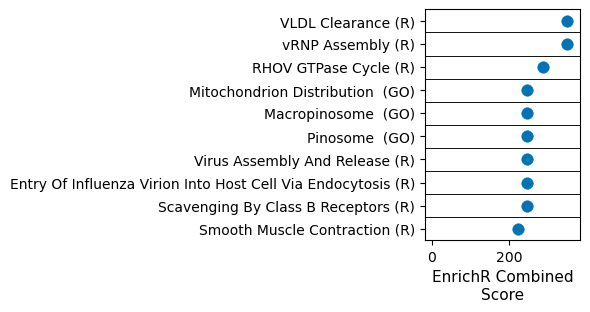

In [13]:
from ptm_pose import plots as pose_plots

pose_plots.plot_EnrichR_pies(gene_set_enrichment, top_terms = 10)

### Protein Interaction Network Analysis

In addition to functional analysis, we can probe which PTMs may impact protein interactions using annotations from things like [PTMcode](https://ptmcode.embl.de/), [PhosphoSitePlus](https://www.phosphosite.org/homeAction.action), [PTMInt](https://ptmint.sjtu.edu.cn/), [ELM](http://elm.eu.org/).

Here, let's focus on interactions annotated in PhosphoSitePlus and PTMcode. First we need to append this information to our spliced ptm data using the annotate module.

In [14]:
#load ptmcode and phosphositeplus data
ptmcode_file = '../../../../Database_Information/PTMcode/PTMcode2_associations_between_proteins.txt.gz'
psp_file = '../../../../Database_Information/PhosphoSitePlus/Regulatory_sites.gz'

#annotate
from ptm_pose import annotate

sig_ptms = annotate.annotate_ptms(sig_ptms, psp_regulatory_site_file = psp_file, PTMcode_interprotein=ptmcode_file)

PhosphoSitePlus regulatory_site information added:
	 ->37 PTMs in dataset found associated with a molecular function 
	 ->31 PTMs in dataset found associated with a biological process
	 ->24 PTMs in dataset found associated with a protein interaction
PTMcode interprotein interactions added: 94 PTMs in dataset found with PTMcode interprotein interaction information

Combining interaction data from multiple databases
PTMcode data found and added
PhosphoSitePlus regulatory site data found and added


Next, we can use the protein_interactions class found in the analyze module to construct PTM-specific protein interaction networks, and analyze the properties of this network

PhosphoSitePlus regulatory site data found and added
PTMcode data found and added


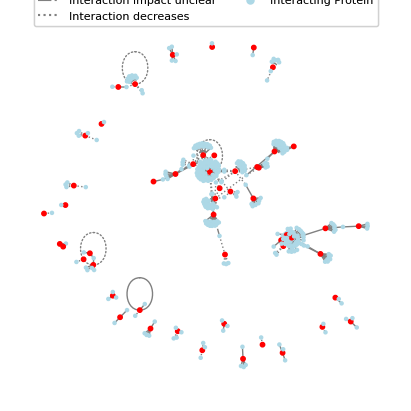

In [16]:
from ptm_pose import analyze

prot_int = analyze.protein_interactions(sig_ptms, interaction_databases = ['PhosphoSitePlus', 'PTMcode'])
prot_int.plot_interaction_network()

We can look at the network statistics to identify the most impacted genes:

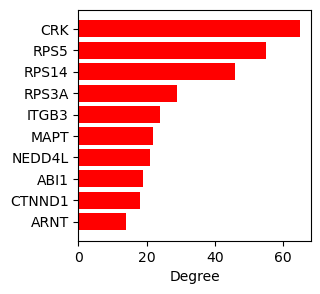

In [17]:
prot_int.plot_network_centrality()

We can also probe the individual interactions by looking at the network data attribute

In [18]:
prot_int.network_data.head()

,Modified Gene,Interacting Gene,Residue,Type,Source,dPSI,Regulation Change
0,ABI1,ABL1,T328;S323;S329;S327;S338;T324;T336;Y333;S361;S...,INDUCES,PTMcode,-0.1084118055555556,-
1,ABI1,BAIAP2,T328;S323;S329;S327;S338;T324;T336;Y333;S361;S...,INDUCES,PTMcode,-0.1084118055555556,-
2,ABI1,CRK,T328;S323;S329;S327;S338;T324;T336;Y333;S326;S...,INDUCES,PTMcode,-0.1084118055555556,-
3,ABI1,CYFIP2,T328;S323;S329;S327;S338;T324;T336;Y333;S361;S...,INDUCES,PTMcode,-0.1084118055555556,-
4,ABI1,ENAH,T328;S323;S329;S327;S338;T324;T336;Y333;S326;S...,INDUCES,PTMcode,-0.1084118055555556,-


## Kinases impacted by splicing

In addition to general protein interactions, PTMs also allow us to probe how different protein isoforms may be regulated, and whether splicing induces coordinated changes for certain kinases.

We can either do this using known annotated kinases from PhosphoSitePlus and RegPhos, or by using predicted kinase substrates from KSTAR/NetworKIN.

### Known kinase substrates 

To look at known kinase substrates, we need to download kinase substrate information from PhosphoSitePlus, then use the annotate module to append this information to our spliced ptms dataset.

In [20]:
psp_ks_file = '../../../../Database_Information/PhosphoSitePlus/Kinase_Substrate_Dataset.gz'

sig_ptms = annotate.add_PSP_kinase_substrate_data(sig_ptms, psp_ks_file, report_success=True)

PhosphoSitePlus kinase-substrate interactions added: 40 phosphorylation sites in dataset found associated with a kinase in PhosphoSitePlus


We can then check which kinases are associated with the spliced phosphorylation sites either 1) visually:

<Axes: title={'center': 'PhosphoSitePlus'}, xlabel='Number of Phosphosites\ntargeted by Kinase'>

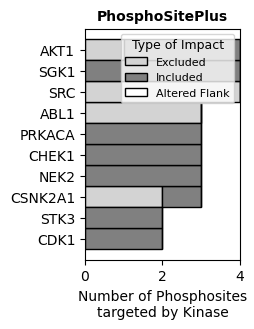

In [22]:
from ptm_pose import plots as pose_plots

pose_plots.plot_annotations(sig_ptms, database = "PhosphoSitePlus", annot_type = 'Kinase', top_terms = 10)

Or directly by looking at sig_ptms dataframe:

In [27]:
from ptm_pose import analyze

annotations, counts = analyze.get_ptm_annotations(sig_ptms, database = 'PhosphoSitePlus', annotation_type='Kinase')
annotations.head()

,Gene,UniProtKB Accession,Residue,PTM Position in Isoform,Modification Class,PSP:Kinase,dPSI,Impact
0,ARNT,P27540,S,77.0,Phosphorylation,CSNK2A1,-0.1279834975369457,Excluded
1,ATG16L1,Q676U5,S,278.0,Phosphorylation,ULK1;CHUK,-0.1566092165898618,Excluded
2,CLDN11,O75508,Y,191.0,Phosphorylation,PTK2,-0.2694419981060606,Excluded
3,CLDN11,O75508,Y,192.0,Phosphorylation,PTK2,-0.2694419981060606,Excluded
4,CRK,P46108,Y,221.0,Phosphorylation,ABL1;ABL2,-0.1128893353174602,Excluded


We can also perform enrichment on the annotations, although it is common for no enrichment to be found due to sparsity of data:

In [29]:
from ptm_pose import analyze

analyze.annotation_enrichment(sig_ptms, database = 'PhosphoSitePlus', annotation_type = 'Kinase').head()

Using pregenerated background information on all PTMs in the proteome.


,Fraction Impacted,p-value,Adjusted p-value,PTM
PSP:Kinase,,,,
SGK1,4/52,0.000071,0.001904,NEDD4L_S342;NEDD4L_S448;NEDD4L_T367;TSC2_S981
NEK2,3/36,0.000471,0.006361,NEK2_S397;NEK2_S402;NEK2_S428
PTK2,2/27,0.005732,0.051586,CLDN11_Y191;CLDN11_Y192
STK3,2/35,0.009504,0.064151,NEK2_S406;NEK2_S438
SRPK2,1/4,0.016636,0.089833,MAPT_S214


### Predicted differentially included kinase substrates

To overcome limitations of sparse kinase-substrate information, we have also provided tools to perform kinase-substrate enrichment analysis using kinase-substrate predictions, based on an adapted version of a kinase activity algorithm ([KSTAR](https://www.nature.com/articles/s41467-022-32017-5))

In order to run this, you need to download KSTAR networks from the [figshare here](https://figshare.com/articles/dataset/NETWORKS/14944305), and then point to the directory containing the network files.

In [32]:
#perform kstar enrichment for tyrosine phosphorylation, denoted by "Y"
network_dir = './NetworKIN/'
kstar_enrichment = analyze.kstar_enrichment(sig_ptms, network_dir = network_dir, phospho_type = ['Y', 'ST'])
kstar_enrichment.run_kstar_enrichment()
kstar_enrichment.return_enriched_kinases()

{'Y': array(['KDR', 'CSF1R'], dtype=object),
 'ST': array(['ROCK1', 'CDK2', 'CAMK2B', 'PRKAA2', 'AURKA', 'SGK3', 'NEK2',
        'PAK3', 'AKT3', 'AKT1', 'MAP2K6', 'RPS6KA3', 'PRKAA1', 'TLK2',
        'PDK1', 'SGK2', 'CDK1', 'SGK1', 'MAP2K4', 'GSK3B', 'ROCK2',
        'PRKCE', 'TGFBR2', 'GSK3A', 'GRK2', 'MAP2K7', 'MAPK7'],
       dtype=object)}